# Prediction with final model on unseen test set

In [1]:
# imports
import xgboost as xgb
import pandas as pd
import numpy as np
import yaml
from python_scripts.model_performance import generate_df_summary

# import model
model = xgb.XGBClassifier()
model.load_model('saved_models/final_model/final_model.json')

# import test data
X_test = pd.read_parquet('data/X_test.parquet')
y_test = pd.read_csv('data/y_test.csv')


In [2]:
# predict on test set using optimised threshold
with open('model_settings.yaml', 'r') as file:
    model_settings = yaml.safe_load(file)
best_threshold = model_settings['best_threshold']

y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= best_threshold).astype(int)

In [19]:
generate_df_summary(model, y_test, y_pred, 'final_model_test', threshold=best_threshold)


Precision: 0.28
Recall: 0.27
F1-Score: 0.28

Confusion Matrix:

               Pred Class 0  Pred Class 1
True Class 0         94434           981
True Class 1          1041           387


## Evaluate final model

Accuracy: 0.9791208450791488
Precision: 0.28289473684210525
Recall: 0.2710084033613445
F1 Score: 0.27682403433476394
ROC AUC Score: 0.894469680656416

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     95415
           1       0.28      0.27      0.28      1428

    accuracy                           0.98     96843
   macro avg       0.64      0.63      0.63     96843
weighted avg       0.98      0.98      0.98     96843



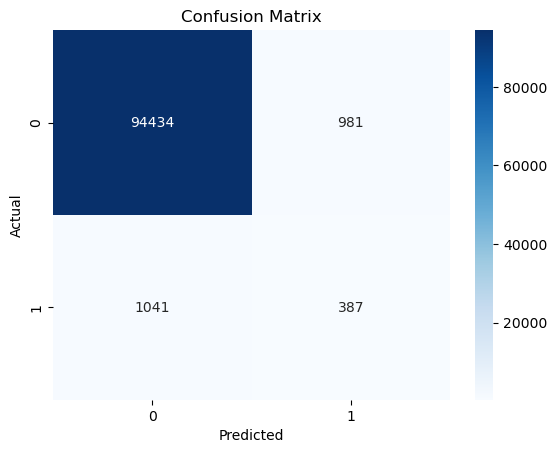

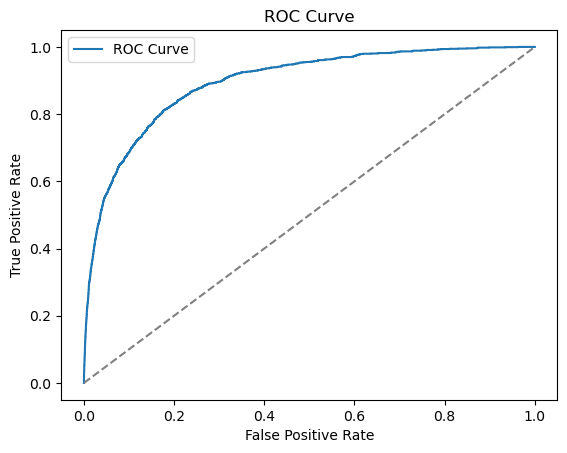

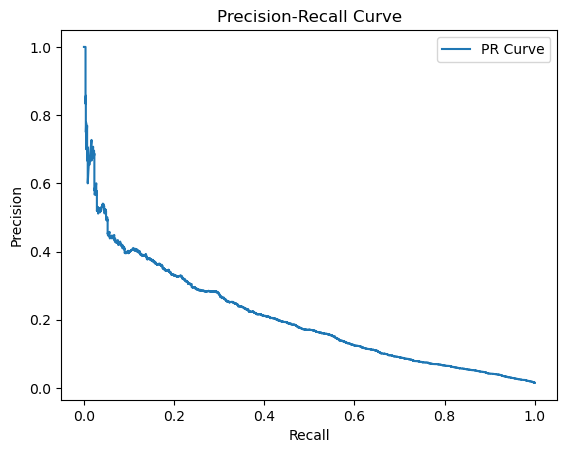

In [3]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Basic metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


## Final model explainability

 99%|===================| 96212/96843 [02:13<00:00]        

The following graphs show the global feature importance of specific variables:
Most important feature: device_os_windows


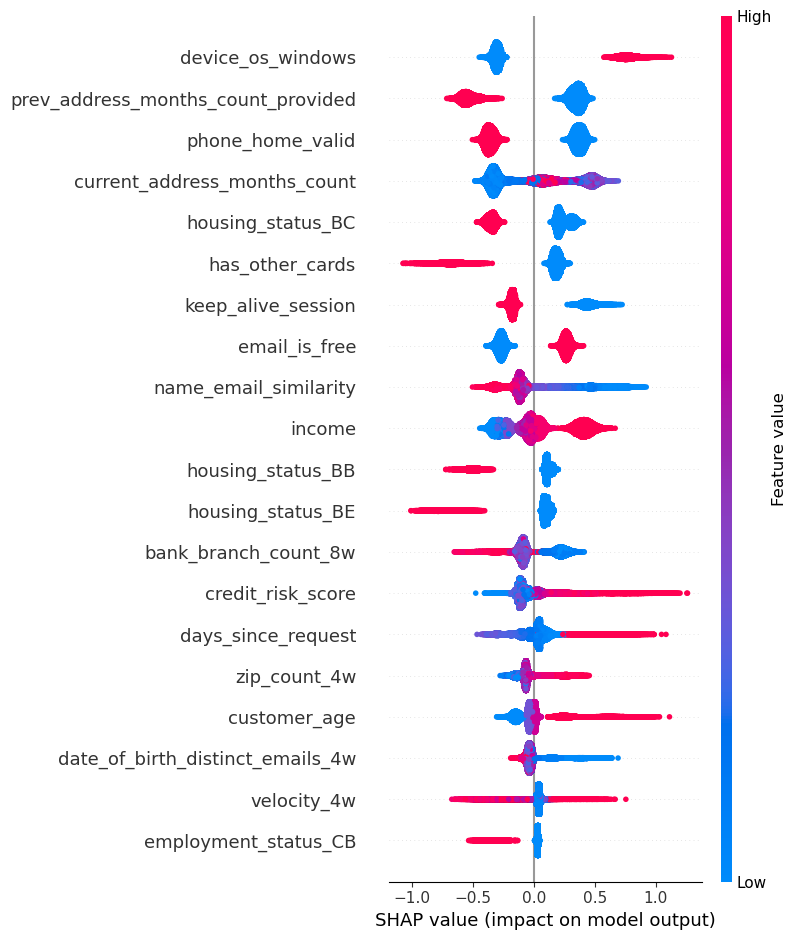

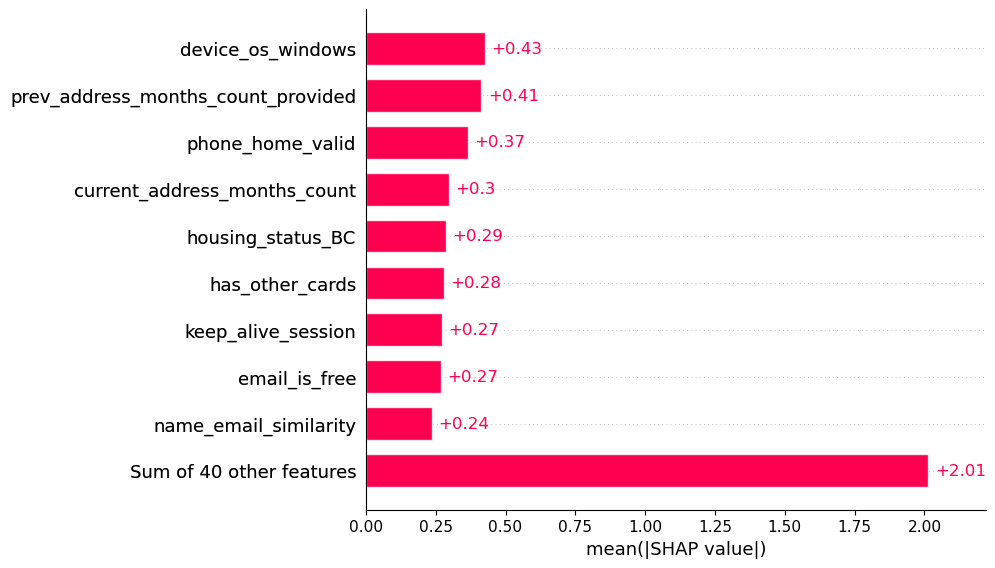

LOOKING AT AN EXAMPLE PREDICTION FROM TEST SET

Log odds base predicition: E[f(X)] = -4.5451110237901755
Converted base predicition: 0.010507415510869363

Log odds predicition for this specific example: -4.909933229130054
Converted predicition: 0.007319017640079422
Threshold for positive fraud prediciton: 0.33831683

Model Decision: Not Fraud


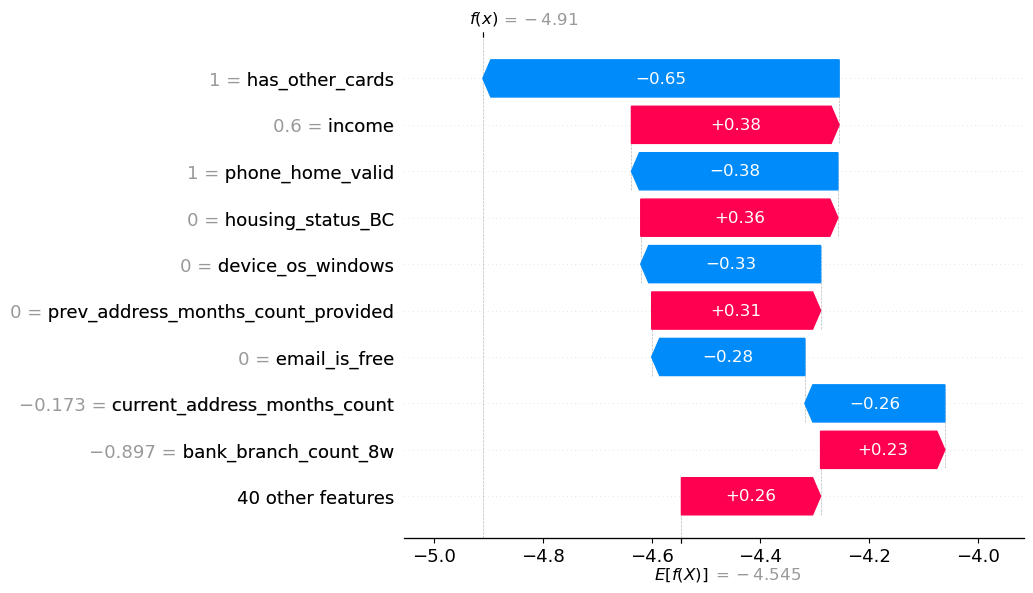

In [4]:
import shap
from scipy.special import expit

# Create SHAP explainer for XGBoost
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

# global feature importance
print("The following graphs show the global feature importance of specific variables:")
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
most_important_idx = np.argmax(mean_abs_shap)
most_important_feature = shap_values.feature_names[most_important_idx]
print("Most important feature:", most_important_feature)
shap.summary_plot(shap_values, X_test)
shap.plots.bar(shap_values)

# explanation for a specific prediction with waterfall chart
log_odds_base = shap_values.base_values[0]
log_odds_specific_prediction = log_odds_base + shap_values.values[0].sum()
prob_base = expit(log_odds_base)
prob_specific_prediction = expit(log_odds_specific_prediction)
print("LOOKING AT AN EXAMPLE PREDICTION FROM TEST SET\n")
print("Log odds base predicition: E[f(X)] =", log_odds_base)
print("Converted base predicition:", prob_base)
print("\nLog odds predicition for this specific example:", log_odds_specific_prediction)
print("Converted predicition:", prob_specific_prediction)
print("Threshold for positive fraud prediciton:", best_threshold)
print("\nModel Decision:" , "Fraud" if prob_specific_prediction >= best_threshold else "Not Fraud")

shap.plots.waterfall(shap_values[0])  


## Measuring impact

#### Using approximate values of 500 dollars cost for a false positive fraud prediciton associated with losing additional business from a legitimate client, and 5000 dollars cost for missing a fraudster through a false negative fraud prediction.

In [44]:
false_positive_cost = 500
false_negative_cost = 5000

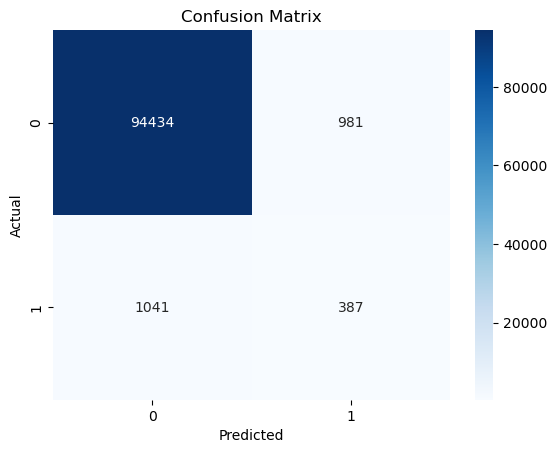

In [45]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [57]:
# without model interference
earning_from_genuine_customers = cm[0].sum() * false_positive_cost
cost_from_fraudulent_customers = cm[1].sum() * false_negative_cost
earnings_before = int(earning_from_genuine_customers - cost_from_fraudulent_customers)

# with model intervention
earning_from_genuine_customers_with_model = cm[0][0] * false_positive_cost
cost_from_fraudulent_customers_with_model = cm[1][0] * false_negative_cost
earnings_with_model = int(earning_from_genuine_customers_with_model - cost_from_fraudulent_customers_with_model)

print('Earnings Before Model: $' + str(earnings_before))
print('Earnings with Model: $' + str(earnings_with_model) +'\n')


print('Genuine Business Lost: $' + str(cm[0][1] * false_positive_cost))
print('Prevented Losses from Fraud: $' + str(cm[1][1] * false_negative_cost))
print('Net Gain: $' + str(earnings_with_model - earnings_before))
print('Percentage net gain in earnings: ' + str(round((earnings_with_model - earnings_before) / earnings_before * 100, 2)) + '%')

Earnings Before Model: $40567500
Earnings with Model: $42012000

Genuine Business Lost: $490500
Prevented Losses from Fraud: $1935000
Net Gain: $1444500
Percentage net gain in earnings: 3.56%
